# Import Library and Dataset

In [287]:
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import closing
from skimage.measure import label, regionprops, regionprops_table
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import seaborn as sns

In [288]:
data = pd.read_csv('leaf_data.csv')
data.head()

,area,eccentricity,major_axis_length,minor_axis_length,label
0,371447,0.537726,753.297041,635.119650,MO
1,554048,0.193027,851.226953,835.218237,MO
2,316128,0.458434,674.651837,599.582138,MO
3,327667,0.207224,654.478893,640.272433,MO
4,389112,0.406810,739.802871,675.819245,MO


In [289]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   area               125 non-null    int64  
 1   eccentricity       125 non-null    float64
 2   major_axis_length  125 non-null    float64
 3   minor_axis_length  125 non-null    float64
 4   label              125 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 5.0+ KB


In [290]:
data.describe()

,area,eccentricity,major_axis_length,minor_axis_length
count,125.000000,125.000000,125.000000,125.000000
mean,541403.792000,0.590412,1078.771626,699.462637
std,191488.546613,0.226206,312.942561,243.288873
min,194075.000000,0.170271,547.748789,165.940242
25%,388235.000000,0.443197,868.238963,599.582138
50%,583727.000000,0.549228,1009.391084,787.728466
75%,695987.000000,0.647364,1142.501947,880.929524
max,951351.000000,0.995568,1916.487980,1031.052182


In [291]:
data.shape

(125, 5)

In [292]:
data['label'].unique()

array(['MO', 'CL', 'AG', 'J', 'M'], dtype=object)

In [293]:
data['label'].value_counts()

MO    25
J     25
M     25
CL    25
AG    25
Name: label, dtype: int64

In [294]:
data.isna().sum()

area                 0
eccentricity         0
major_axis_length    0
minor_axis_length    0
label                0
dtype: int64

# Splitting Data Etc.

### Label Encoding

In [295]:
df = data.copy()
df.head()

,area,eccentricity,major_axis_length,minor_axis_length,label
0,371447,0.537726,753.297041,635.119650,MO
1,554048,0.193027,851.226953,835.218237,MO
2,316128,0.458434,674.651837,599.582138,MO
3,327667,0.207224,654.478893,640.272433,MO
4,389112,0.406810,739.802871,675.819245,MO


In [296]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [297]:
labelencoder = LabelEncoder()
df['label'] = labelencoder.fit_transform(df['label'])

In [298]:
df.head()

,area,eccentricity,major_axis_length,minor_axis_length,label
0,371447,0.537726,753.297041,635.119650,4
1,554048,0.193027,851.226953,835.218237,4
2,316128,0.458434,674.651837,599.582138,4
3,327667,0.207224,654.478893,640.272433,4
4,389112,0.406810,739.802871,675.819245,4


In [299]:
info = {df['label'][i] : data['label'][i] for i in range(len(data))}
dict(sorted(info.items(), key=lambda x:int(x[0])))

{0: 'AG', 1: 'CL', 2: 'J', 3: 'M', 4: 'MO'}

### Data Correlation

In [300]:
df.corr()

,area,eccentricity,major_axis_length,minor_axis_length,label
area,1.000000,-0.486446,-0.253450,0.893979,0.081858
eccentricity,-0.486446,1.000000,0.839921,-0.795416,-0.759126
major_axis_length,-0.253450,0.839921,1.000000,-0.622217,-0.830351
minor_axis_length,0.893979,-0.795416,-0.622217,1.000000,0.450792
label,0.081858,-0.759126,-0.830351,0.450792,1.000000


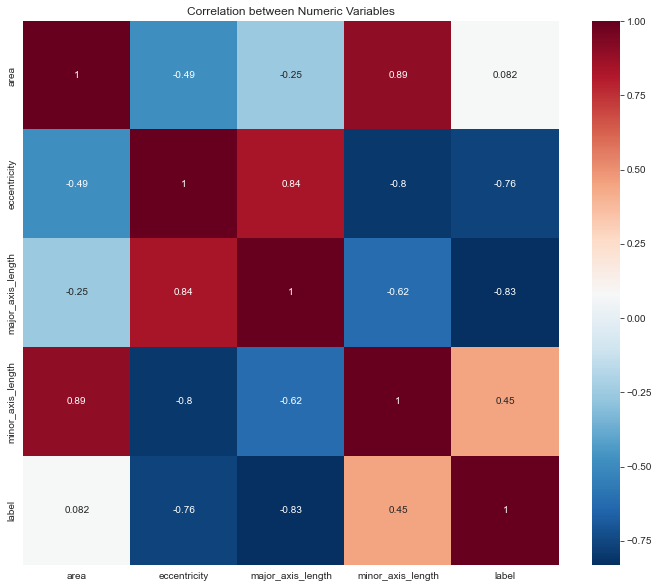

In [301]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap="RdBu_r",annot=True)

plt.title('Correlation between Numeric Variables')
plt.show()

### Splitting Data

In [302]:
from sklearn.model_selection import train_test_split

In [303]:
X = df.iloc[:, :-1].values

In [304]:
y = df.iloc[:, -1]

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

### Scaling Data

In [306]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# kNN Model

In [307]:
from sklearn.neighbors import KNeighborsClassifier
k = 3
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train,y_train)
print(" {} nn score: {} ".format(k,knn.score(X_test,y_test)))

 3 nn score: 0.5263157894736842 


In [308]:
y_pred = knn.predict(X_test)
y_true = y_test

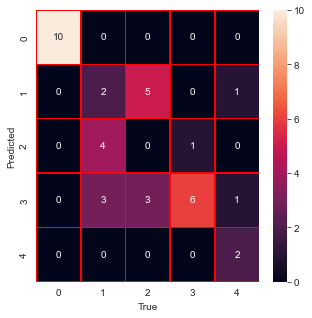

In [309]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [310]:
#K fold CV K = 10
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(knn,X,y, cv = 10)

for i in range(len(accuracies)):
  print("K{} = {}".format(i, accuracies[i]))

print("\naverage accuracy: ",np.mean(accuracies))
print("average std: ",np.std(accuracies))

K0 = 0.38461538461538464
K1 = 0.6923076923076923
K2 = 0.5384615384615384
K3 = 0.46153846153846156
K4 = 0.38461538461538464
K5 = 0.3333333333333333
K6 = 0.5
K7 = 0.4166666666666667
K8 = 0.5833333333333334
K9 = 0.3333333333333333

average accuracy:  0.4628205128205128
average std:  0.11053929125538395


In [311]:
y_pred_knn = knn.predict(X_test)
print("KNN Classifier report: \n\n", classification_report(y_test, y_pred_knn))

KNN Classifier report: 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.22      0.25      0.24         8
           2       0.00      0.00      0.00         5
           3       0.86      0.46      0.60        13
           4       0.50      1.00      0.67         2

    accuracy                           0.53        38
   macro avg       0.52      0.54      0.50        38
weighted avg       0.63      0.53      0.55        38



### Find Best K Value

In [312]:
error_rate=[]#list that will store the average error rate value of k
acc_rate = []
for i in range (1,11):  #Took the range of k from 1 to 30
    clf=KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train,y_train)
    predict_i=clf.predict(X_test)
    score = clf.score(X_test, y_test)
    acc_rate.append(score)
    error_rate.append(np.mean(predict_i!=y_test))

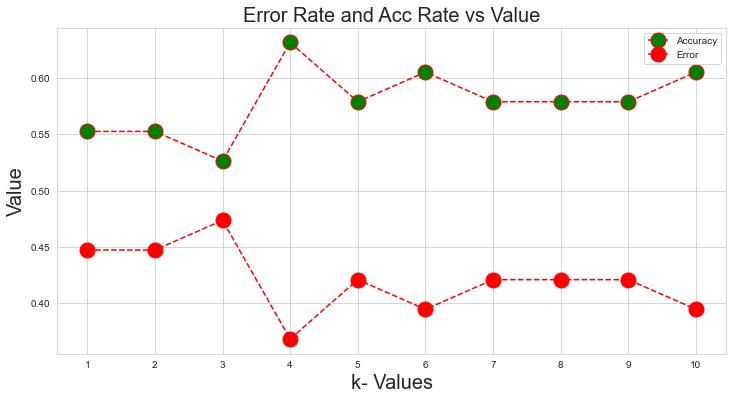

In [313]:
#plotting the error rate vs k graph 
plt.figure(figsize=(12,6))
plt.plot(range(1,11),acc_rate,label="Accuracy",marker="o",markerfacecolor="green", linestyle="dashed",color="red",markersize=15)
plt.plot(range(1,11),error_rate,label="Error",marker="o",markerfacecolor="red", linestyle="dashed",color="red",markersize=15)
plt.title("Error Rate and Acc Rate vs Value",fontsize=20)
plt.xlabel("k- Values",fontsize=20)
plt.ylabel("Value",fontsize=20)
plt.xticks(range(1,11))
plt.legend()
plt.show()

### Rebuild Best Model

In [314]:
from sklearn.neighbors import KNeighborsClassifier
k = 4
knn_best = KNeighborsClassifier(n_neighbors = k)
knn_best.fit(X_train,y_train)
print(" {} nn score: {} ".format(k,knn_best.score(X_test,y_test)))

 4 nn score: 0.631578947368421 


In [315]:
y_pred2 = knn_best.predict(X_test)
y_true = y_test

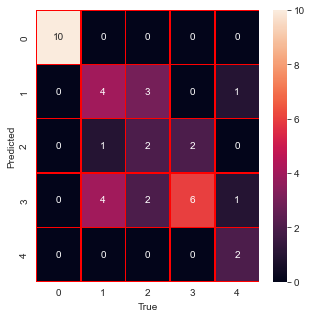

In [316]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_true,y_pred2)

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm2,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [317]:
#K fold CV K = 10
from sklearn.model_selection import cross_val_score
accuracies2 = cross_val_score(knn_best,X,y, cv = 10)

for i in range(len(accuracies2)):
  print("K{} = {}".format(i, accuracies2[i]))

print("\naverage accuracy: ",np.mean(accuracies2))
print("average std: ",np.std(accuracies2))

K0 = 0.46153846153846156
K1 = 0.6153846153846154
K2 = 0.5384615384615384
K3 = 0.46153846153846156
K4 = 0.3076923076923077
K5 = 0.3333333333333333
K6 = 0.5
K7 = 0.5
K8 = 0.6666666666666666
K9 = 0.3333333333333333

average accuracy:  0.4717948717948718
average std:  0.11406654574120627


In [318]:
y_pred_knn2 = knn_best.predict(X_test)
print("KNN Classifier report: \n\n", classification_report(y_test, y_pred_knn2))

KNN Classifier report: 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.44      0.50      0.47         8
           2       0.29      0.40      0.33         5
           3       0.75      0.46      0.57        13
           4       0.50      1.00      0.67         2

    accuracy                           0.63        38
   macro avg       0.60      0.67      0.61        38
weighted avg       0.68      0.63      0.64        38



# Saving Best Model

In [319]:
import pickle

In [320]:
filename = 'knn_best_model.sav'

In [321]:
# pickle.dump(knn_best, open(filename, 'wb'))

In [322]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result) 

0.631578947368421


# Testing with Some Input

In [353]:
def predict_img(input_img, model):
  X_input = sc.transform(input_img)
  pred_input = model.predict(X_input)
  return pred_input

In [362]:
image_path = "input/CL-S-009.png"

In [363]:
image = rgb2gray(imread(image_path))
label_img = label(image)

table = pd.DataFrame(regionprops_table(label_img, image,
                        ['area', 'eccentricity',                         
                        'major_axis_length', 'minor_axis_length']))

input_img = table.copy()
input_img.head()

,area,eccentricity,major_axis_length,minor_axis_length
0,1191,1.00000,1375.247856,0.000000
1,655900,0.64512,1049.184479,801.661884


In [364]:
X_input = input_img.loc[[1]].values

In [365]:
X_input

array([[6.55900000e+05, 6.45120366e-01, 1.04918448e+03, 8.01661884e+02]])

In [366]:
pred_input = predict_img(X_input, loaded_model)

In [367]:
print("Hasil Prediksi - {}".format(image_path))
print("{} - {}".format(pred_input, info[pred_input[0]]))

Hasil Prediksi - input/CL-S-009.png
[1] - CL
